# Multiome

In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc

from os.path import join
import matplotlib.pyplot as plt

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' 

In [2]:
# Path to the data directory
dat_dir = "/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/datasets/"
data_dir = os.path.join(dat_dir, "match_modality/openproblems_bmmc_multiome_phase2_rna")

## Read Data

In [3]:
print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod1.h5ad'))
input_train_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod2.h5ad'))
input_train_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_sol.h5ad'))
input_test_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod1.h5ad'))
input_test_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad'))

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
train_mod2_ord = ord.copy()
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names

mod1_feature_type = set(input_train_mod1.var["feature_types"])
mod2_feature_type = set(input_train_mod2.var["feature_types"])

mod1_feature_type, mod2_feature_type

Reading `h5ad` files...
Unscrambling training cells...


({'GEX'}, {'ATAC'})

## HVG/HVPs

In [4]:
# sc.pp.highly_variable_genes(input_train_mod1, layer='counts', flavor='seurat_v3', n_top_genes=5000)
sc.pp.highly_variable_genes(input_train_mod1, n_top_genes=5000, batch_key='batch')
hvg_names = input_train_mod1.var.query('highly_variable').index.to_numpy()

hvp_idx = np.argsort(input_train_mod2.layers['counts'].sum(axis=0).A1)[-20000:]
hvp_names = input_train_mod2.var_names[hvp_idx].to_numpy()

In [5]:
mult_rna_count = input_train_mod1[:, hvg_names].layers["counts"].astype(np.float32)
mult_atac_count = input_train_mod2[:, hvp_names].layers["counts"].astype(np.float32)
# mult_rna_count = input_train_mod1[:, hvg_names].X.astype(np.float32)
# mult_atac_count = input_train_mod2[:, hvp_names].X.astype(np.float32)
mult_rna_count = sps.csr_matrix(mult_rna_count)   # this fucking thing must be in csr format, otherwise, training will be fucking very 
mult_atac_count = sps.csr_matrix(mult_atac_count)   # slowly, fuck, fuck, fuck
mult_barcode = input_train_mod1.obs_names.to_numpy()

rna_feature = hvg_names
atac_feature = hvp_names

Alternatively, a `SingleData` object can also be constructed using a processed
scipy sparse matrix of counts and string arrays of feature and barcode names.
We show an example below for reading the mRNA data from sparse matrix.

In [6]:
mult_rna = SingleData("GeneExpr", "Multiome", rna_feature, mult_rna_count, mult_barcode)
mult_atac = SingleData("ATAC", "Multiome", atac_feature, mult_atac_count, mult_barcode)

In [7]:
single_rna_count = input_test_mod1[:, hvg_names].layers["counts"].astype(np.float32)
single_atac_count = input_test_mod2[:, hvp_names].layers["counts"].astype(np.float32)
# single_rna_count = input_test_mod1[:, hvg_names].X.astype(np.float32)
# single_atac_count = input_test_mod2[:, hvp_names].X.astype(np.float32)
single_rna_count = sps.csr_matrix(single_rna_count)
single_atac_count = sps.csr_matrix(single_atac_count)
single_rna_barcode = input_test_mod1.obs_names.to_numpy()
single_atac_barcode = input_test_mod2.obs_names.to_numpy()

rna_feature = hvg_names
atac_feature = hvp_names

In [8]:
single_atac_barcode

array(['0', '1', '2', ..., '20006', '20007', '20008'], dtype=object)

In [9]:
single_rna = SingleData("GeneExpr", "Single-GEX", rna_feature, single_rna_count, single_rna_barcode)
single_atac = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count, single_atac_barcode)

Merge the above three datasets. Cells with the identical barcode names and
dataset names are recognized as joint cells. Cobolt focus on common features
shared across datasets. Genes are subset to those detected by both SNARE-seq
and scRNA-seq. We also performed preprocessing that mapped the SNARE-seq
chromatin accessibility counts to peaks called on the scATAC-seq dataset, such
that they share the same feature set. A batch variable is
automatically added when merging datasets. Different datasets are treated as
different batches.

In [10]:
multi_dt = MultiomicDataset.from_singledata(
    single_rna, single_atac, mult_atac, mult_rna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- GeneExpr: 5000 features, 62501 cells, 2 batches.
- ATAC: 20000 features, 62501 cells, 2 batches.
Joint cells:
- GeneExpr, ATAC: 42492 cells.


## Training

We now train the Cobolt model with the number of latent variables set to 10. We
use a small iteration in this vignette for illustration purpose. The default
number of iteration is set to 100.

In [ ]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

 18%|██████████████████████████████▊                                                                                                                                            | 18/100 [11:00<50:44, 37.12s/it]

Calculate the corrected latent variables.

In [ ]:
plt.plot(model.history['loss'])

In [ ]:
model.calc_all_latent()

latent = model.get_all_latent()

# latent_raw = model.get_all_latent(correction=False)

### Evaluation

In [11]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

In [12]:
# Set metadata
gex_test = sc.AnnData(single_rna_count)
gex_test.obs_names = single_rna_barcode
other_test = sc.AnnData(single_atac_count)
other_test.obs_names = single_atac_barcode

ad_mult = sc.AnnData(mult_rna_count)
ad_mult.obs_names = mult_barcode

In [13]:
if False:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/multiome.csv')

else:
    df_latent = pd.read_csv('./outputs/multiome.csv', index_col=0)
    df_latent.index = df_latent.index.astype('str')

/tmp/ipykernel_18173/2104401324.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_latent = pd.read_csv('./outputs/multiome.csv', index_col=0)


In [14]:
ad_mult.obsm['X_emb'] = df_latent.loc[ad_mult.obs_names, :].values
gex_test.obsm['X_emb'] = df_latent.loc[gex_test.obs_names, :].values
other_test.obsm['X_emb'] = df_latent.loc[other_test.obs_names, :].values

In [15]:
input_test_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_sol.h5ad'))

test_ord = input_test_sol.X.tocsr().indices
assert (test_ord == np.argsort(input_test_sol.uns['pairing_ix'])).all()

In [16]:
other_test = other_test[test_ord, :].copy()
other_test.obs_names = gex_test.obs_names.to_numpy()

In [17]:
# rename to be consistent with meta data
def renames(df):
    df['full_names'] = df.index.to_numpy()
    df.index = [_.split('-')[0]+'-'+_.split('-')[1] for _ in df.index]
    return df

root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
df_meta = pd.read_csv(os.path.join(root_dir, 'output/datasets/multiome_meta.csv'), index_col=0)
df_meta = renames(df_meta)
train_idx = ~df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
test_idx  = df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])

In [18]:
# Set metadata
gex_test.obs = renames(gex_test.obs)
other_test.obs = renames(other_test.obs)
ad_mult.obs = renames(ad_mult.obs)

ad_mult.obs[['batch', 'cell_type']] = df_meta.loc[train_idx].loc[ad_mult.obs_names, ['batch', 'cell_type']].to_numpy()
gex_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[gex_test.obs_names, ['batch', 'cell_type']].to_numpy()
other_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[other_test.obs_names, ['batch', 'cell_type']].to_numpy()

ad_mult.obs['mod'] = 'multiome'
gex_test.obs['mod'] = 'gex'
other_test.obs['mod'] = 'other'
ad_mult.obs['mod-batch'] = ad_mult.obs.batch.apply(lambda x: 'multiome'+'-'+x).to_numpy()
gex_test.obs['mod-batch'] = gex_test.obs.batch.apply(lambda x: 'gex'+'-'+x).to_numpy()
other_test.obs['mod-batch'] = other_test.obs.batch.apply(lambda x: 'other'+'-'+x).to_numpy()

In [20]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering

### (1) Mosaic eval

### 1.1 without harmony

In [29]:
ad_mosaic = sc.concat([ad_mult, gex_test, other_test])

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch', 'mod'], use_rep='X_emb')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


mod-batch_LISI=0.18605
mod_LISI=0.50329
Compute neighbors using X_emb
GC=0.95429
NMI=0.75492
ARI=0.67392


In [30]:
ad_mosaic = sc.concat([ad_mult, gex_test, other_test])

nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb',
    use='nmi', nmi_method='arithmetic')
nmi, ari

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(0.7549157108571494, 0.673917624798392)

In [31]:
r = eval_bridge(
    gex_test, other_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM=0.04559
Match_score=0.01040


### 1.2 with harmony

In [21]:
from preprocessing import harmony

In [29]:
ad_mosaic = sc.concat([ad_mult, gex_test, other_test])

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch', 'mod'], use_nmi=False, use_rep='X_emb_harmony')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


mod-batch_LISI=0.32182
mod_LISI=0.62110
Compute neighbors using X_emb_harmony
GC=0.93658


In [30]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.72620096487462, 0.6064931362569439)

In [31]:
gex_test.obsm['X_emb_harmony'] = ad_mosaic.obsm['X_emb_harmony'][ad_mult.shape[0]:(ad_mult.shape[0] + gex_test.shape[0])]
other_test.obsm['X_emb_harmony'] = ad_mosaic.obsm['X_emb_harmony'][(-other_test.shape[0]):]

r = eval_bridge(
        gex_test, other_test,
        label_key='cell_type',
        batch_key='batch',
        use_rep='X_emb_harmony',
        use_acc=False
)

FOSCTTM=0.05493
Match_score=0.01023


## Clustering and Visualization

In [22]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [23]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [24]:
ad_mosaic = sc.concat([ad_mult, gex_test, other_test])
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='X_umap_1')

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='X_harmony_umap')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

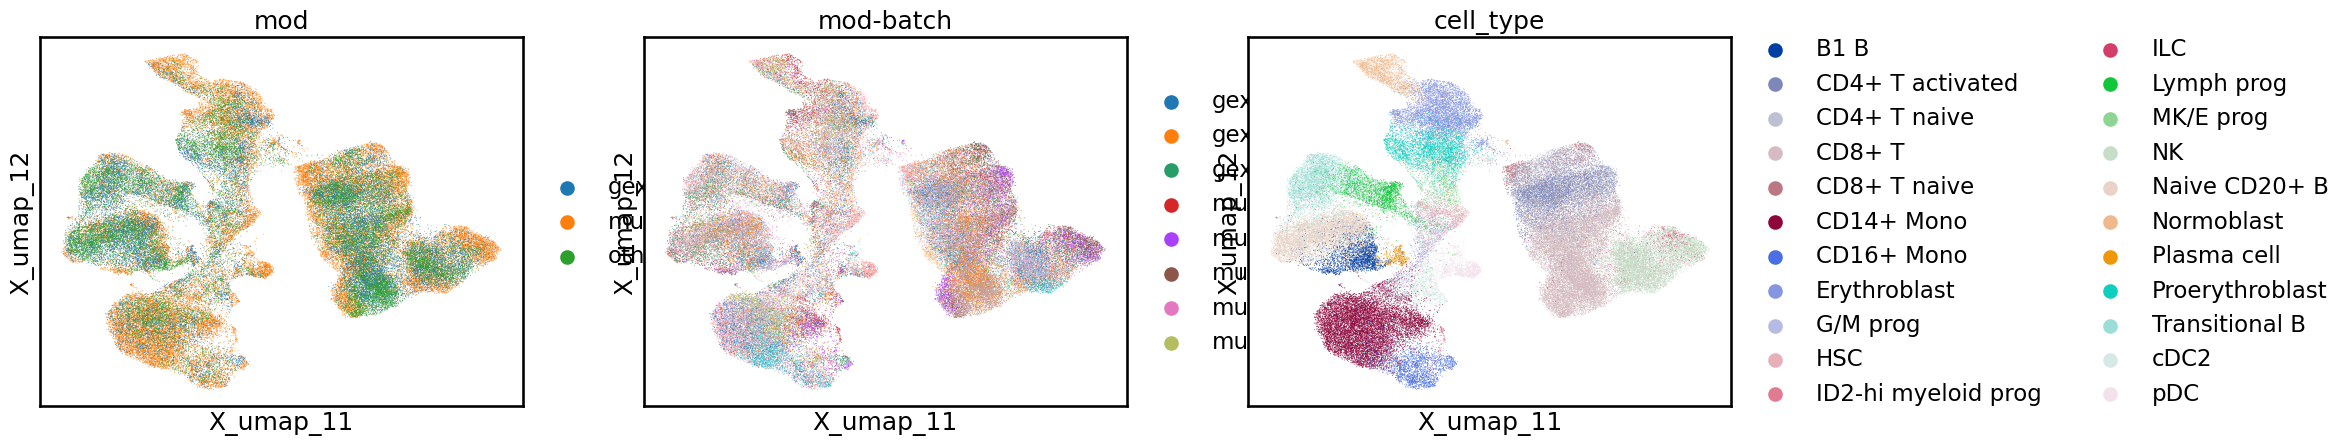

In [25]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['mod', 'mod-batch', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

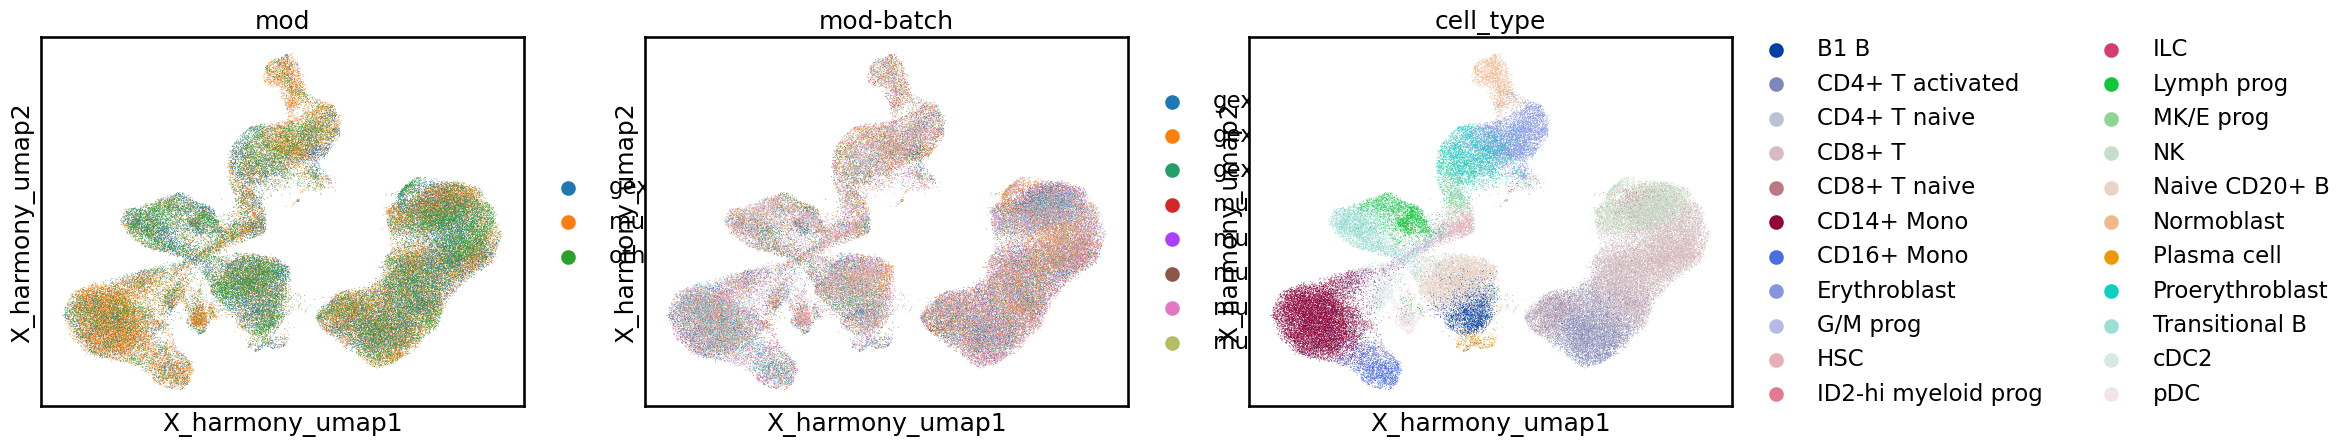

In [26]:
sc.pl.embedding(ad_mosaic, basis='X_harmony_umap', color=['mod', 'mod-batch', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

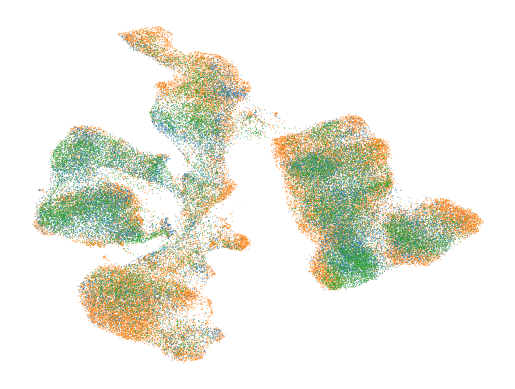

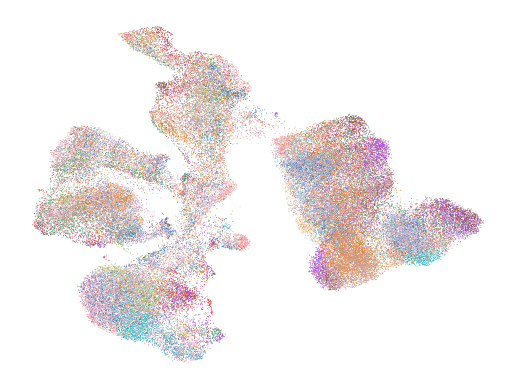

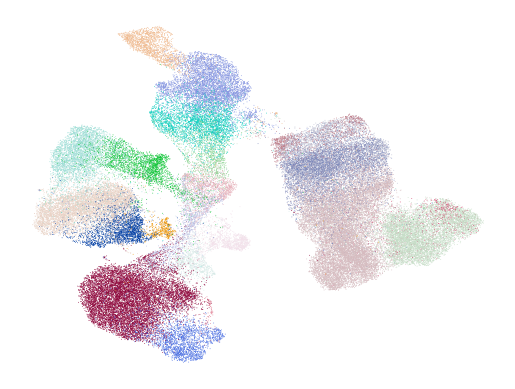

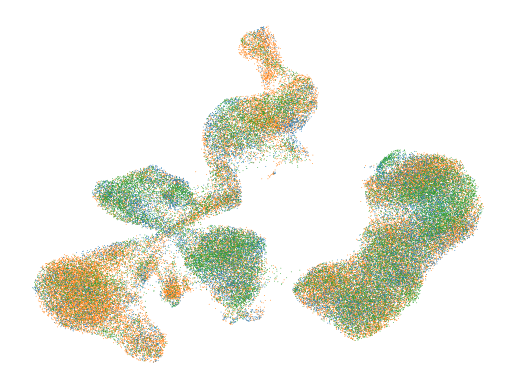

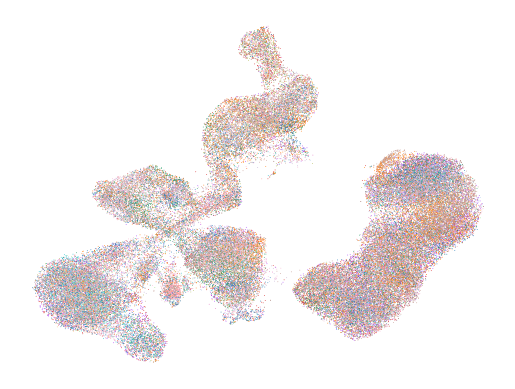

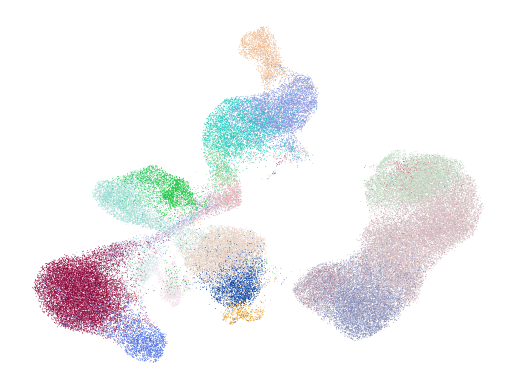

In [27]:
save_umap(ad_mosaic, 'X_umap_1', ['mod', 'mod-batch', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='cobolt_case2_multiome')

save_umap(ad_mosaic, 'X_harmony_umap', ['mod', 'mod-batch', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='cobolt-harmony_case2_multiome')

In [28]:
np.save(join(umap_save_dir, 'cobolt_case2_multiome_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(join(umap_save_dir, 'cobolt-harmony_case2_multiome_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])